# 0. Denoising power density spectrum using convolutional autoencoders.

In this notebook, we attempt to remove noise in power density spectrum of Kepler red giant using convolutional autoencoders.

[The Kepler mission](https://www.science.org/doi/10.1126/science.1185402) was designed to determine the frequency of Earth-sized planets in and near the habitable zone of Sun-like stars. Some of the most fundamental studies are to identify which stars show oscillations and to locate the frequency at maximum power. However, these studies are suffer from noise in signals. 

The aim of this work is to use a very deep convolutional autoencoder to remove noise in power density spectrum of Kepler red giant.



In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

2022-03-04 16:01:00.006931: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Using TensorFlow v2.4.1


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

The data is stored in 'Astronomy/kepler.pickle', containing 6175 power density spectrum of Kepler red giant. The data has been preprocessed a bit using logarithm and median of each sample - so the values are between 0 and 2. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
data_path = join(data_path,'Astronomy/kepler.pickle')
with open(data_path, 'rb') as f:
    x_train = pickle.load(f)[0][:, :2**15] 
```
    
</p>
</details>

In [ ]:
data_path = join(data_path,'Astronomy/kepler.pickle')
with open(data_path, 'rb') as f:
    x_train = pickle.load(f)[0][:, :2**15]  

In [4]:
x_train = np.expand_dims(x_train, -1)
print(x_train.shape)

(6175, 32768, 1)


Text(0.5, 0.95, 'Examples')

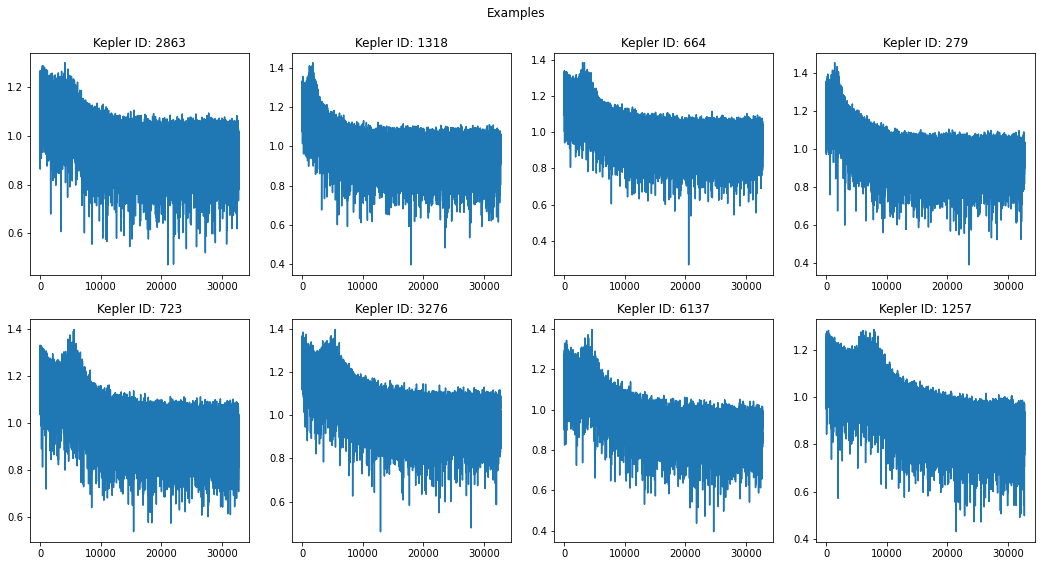

In [5]:
idxs = np.random.choice(len(x_train), 8)

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1))
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))

fig.suptitle('Examples', y = 0.95)

---

# 2. Build the network

The task is to build and train a convolutional autoencoder to remove noise in signals. The signals are 1D array, hence, we use 1D convolution in an encoder and 1D transposed convolution in a decoder.

### The encoder

The encoder contains five 1D convolutional layers, an input layer with size 32768$\times$1 and one dense layer with size 32:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the encoder
image_input = keras.Input(shape=(32768, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv1D(8, 7, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)


x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(32)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()
```
    
</p>
</details>

In [6]:
# build the encoder
image_input = keras.Input(shape=(32768, 1))
#x = layers.Flatten()(image_input)
x = layers.Conv1D(8, 7, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)


x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
latent_output = layers.Dense(32)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()

2022-03-04 16:01:02.665234: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-04 16:01:02.666281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-04 16:01:03.594207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-04 16:01:03.594236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-04 16:01:03.595507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-04 16:01:03.595576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32768, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8192, 8)           64        
_________________________________________________________________
batch_normalization (BatchNo (None, 8192, 8)           32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 16)          656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2048, 16)          1296  

### The decoder

The decoder contains sixe transposed convolutional layers and one dense layer that are reciprocal to those of the encoders and one convolutional layer, outputing denoised signals with the same size as the input signals:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(32))
x = layers.Dense(16384)(latent_input)
x = layers.Reshape((512, 32), input_shape=(16384,))(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
image_output = layers.Conv1D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()
```
    
</p>
</details>

In [7]:
# build the decoder
latent_input = keras.Input(shape=(32))
x = layers.Dense(16384)(latent_input)
x = layers.Reshape((512, 32), input_shape=(16384,))(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(32, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(16, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(8, 5, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
image_output = layers.Conv1D(1, 3, padding = 'same')(x)

decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             540672    
_________________________________________________________________
reshape (Reshape)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1024, 32)          5152      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024, 32)          128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024, 32)          0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 2048, 32)          5152

### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the AE
image_input = keras.Input(shape=(32768, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
```
    
</p>
</details>

In [8]:
# build the AE
image_input = keras.Input(shape=(32768, 1))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32768, 1)]        0         
_________________________________________________________________
model (Functional)           (None, 32)                534496    
_________________________________________________________________
model_1 (Functional)         (None, 32768, 1)          556297    
Total params: 1,090,793
Trainable params: 1,090,361
Non-trainable params: 432
_________________________________________________________________


In [9]:
# train the AE
ae_model.fit(x_train, x_train, epochs=50, batch_size=64)
            

2022-03-04 16:01:06.882734: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-04 16:01:06.907049: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/50


2022-03-04 16:01:08.876214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-04 16:01:09.133295: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-04 16:01:10.148893: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-04 16:01:10.346390: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


97/97 [==============================] - 84s 486ms/step - loss: 0.5463 - mse: 0.5463
Epoch 2/50
97/97 [==============================] - 6s 60ms/step - loss: 0.0178 - mse: 0.0178
Epoch 3/50
97/97 [==============================] - 6s 59ms/step - loss: 0.0097 - mse: 0.0097
Epoch 4/50
97/97 [==============================] - 7s 71ms/step - loss: 0.0079 - mse: 0.0079
Epoch 5/50
97/97 [==============================] - 7s 68ms/step - loss: 0.0068 - mse: 0.0068
Epoch 6/50
97/97 [==============================] - 7s 71ms/step - loss: 0.0063 - mse: 0.0063
Epoch 7/50
97/97 [==============================] - 6s 66ms/step - loss: 0.0059 - mse: 0.0059
Epoch 8/50
97/97 [==============================] - 6s 61ms/step - loss: 0.0057 - mse: 0.0057
Epoch 9/50
97/97 [==============================] - 6s 65ms/step - loss: 0.0056 - mse: 0.0056
Epoch 10/50
97/97 [==============================] - 6s 63ms/step - loss: 0.0054 - mse: 0.0054
Epoch 11/50
97/97 [==============================] - 6s 64ms/step - 

---

# 3. Analyse results 

### Visualize the original signals and denoised signals by AE

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
idxs = [2000, 200, 5959, 1721, 123, 4231, 911, 6127]

y = ae_model.predict(x_train[idxs])

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1), label = 'orignal signal')
        ax[j, i].plot(y[i*2+j].reshape(-1), label = 'denoised signal')
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))
        ax[j, i].legend(loc = 1)

fig.suptitle('examples', y = 0.95)
```
    
</p>
</details>

Text(0.5, 0.95, 'examples')

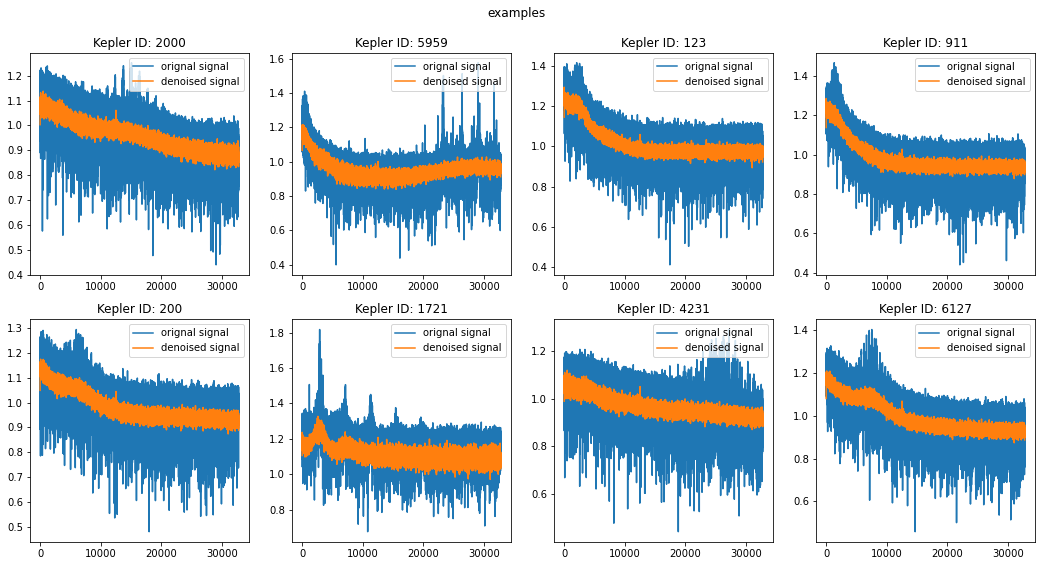

In [10]:
idxs = [2000, 200, 5959, 1721, 123, 4231, 911, 6127]

y = ae_model.predict(x_train[idxs])

fig, ax = plt.subplots(2, 4, figsize = (18, 9))
for j in range(2):
    for i in range(4):
        ax[j, i].plot(x_train[idxs[i*2+j]].reshape(-1), label = 'orignal signal')
        ax[j, i].plot(y[i*2+j].reshape(-1), label = 'denoised signal')
        ax[j, i].set_title('Kepler ID: {}'.format(idxs[i*2+j]))
        ax[j, i].legend(loc = 1)

fig.suptitle('examples', y = 0.95)

---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the performance
* Add noise to input layer to make the network more robust to noise